# **NIFTY 50 Stock Prediction**

Download the dataset from this [link](https://www.kaggle.com/rohanrao/nifty50-stock-market-data)

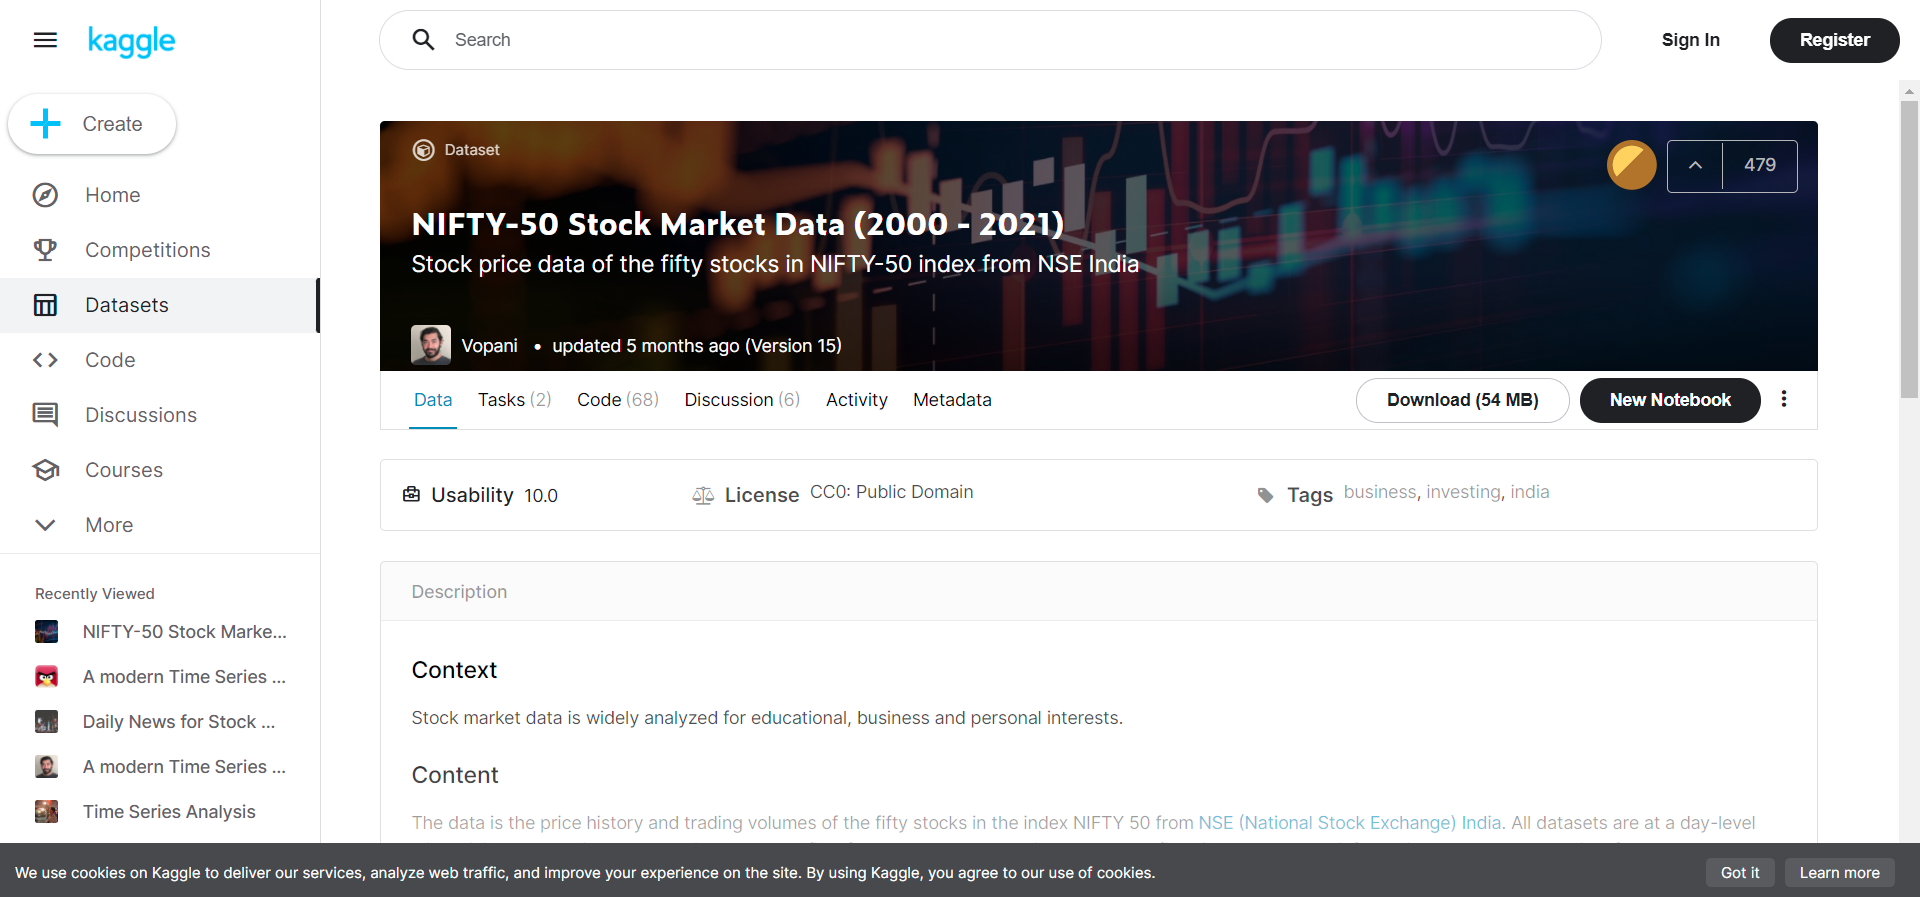

Click on "Download (54 MB)" to download the zip file.

Extract the file and upload the stock you want to predict.

Scroll down to the end of page and get your prediction!

Click on Run all under Runtime tab in colab or press "Ctrl+F9"


In [ ]:
# Importing files for traning and testing

from google.colab import files
uploaded = files.upload()

In [ ]:
# loading imported file

import pandas as pd
import io

fileName = next(iter(uploaded))
symbol = fileName.split('.')[0]
df = pd.read_csv(io.BytesIO(uploaded[fileName]))

In [ ]:
# importing modules

import matplotlib.pyplot as plt
import numpy as np 
import math

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import yfinance as yf

# Generating random seed
np.random.seed(5)

!pip install yfinance

In [ ]:
# Creating Datasets

dataset = pd.read_csv(fileName, usecols=[4,5,6,8])
dataset = dataset.reindex(index = dataset.index[::-1])

OBS = np.arange(1, len(dataset) + 1, 1)

In [ ]:
ohlcAVG = dataset.mean(axis = 1)
hlcAVG = dataset[['High', 'Low', 'Close']].mean(axis = 1)
closeVAL = dataset[['Close']]

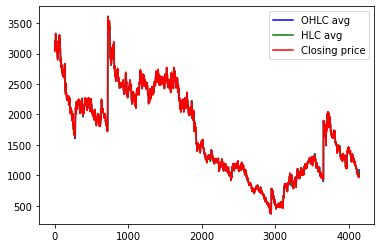

In [ ]:
# Plotting dataset

plt.plot(OBS, ohlcAVG, 'b', label = 'OHLC avg')
plt.plot(OBS, hlcAVG, 'g', label = 'HLC avg')
plt.plot(OBS, closeVAL, 'r', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

In [ ]:
ohlcAVG = np.reshape(ohlcAVG.values, (len(ohlcAVG),1))
scaler = MinMaxScaler(feature_range=(0, 1))
ohlcAVG = scaler.fit_transform(ohlcAVG)

In [ ]:
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [ ]:
# Defining traning and testing dataset

train_OHLC = int(len(ohlcAVG) * 0.70)
test_OHLC = len(ohlcAVG) - train_OHLC
train_OHLC, test_OHLC = ohlcAVG[0:train_OHLC,:], ohlcAVG[train_OHLC:len(ohlcAVG),:]

trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [ ]:
# Creating MODEL

MODEL = Sequential()
MODEL.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
MODEL.add(LSTM(16))
MODEL.add(Dense(1))
MODEL.add(Activation('linear'))

In [ ]:
MODEL.compile(loss='mean_squared_error', optimizer='adam')
MODEL.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
2895/2895 - 8s - loss: 0.0073
Epoch 2/10
2895/2895 - 5s - loss: 2.2757e-04
Epoch 3/10
2895/2895 - 5s - loss: 2.4054e-04
Epoch 4/10
2895/2895 - 5s - loss: 2.3505e-04
Epoch 5/10
2895/2895 - 5s - loss: 2.2803e-04
Epoch 6/10
2895/2895 - 5s - loss: 2.3090e-04
Epoch 7/10
2895/2895 - 5s - loss: 2.2560e-04
Epoch 8/10
2895/2895 - 5s - loss: 2.1666e-04
Epoch 9/10
2895/2895 - 5s - loss: 2.2616e-04
Epoch 10/10
2895/2895 - 5s - loss: 2.2479e-04


In [ ]:
trainPredict = MODEL.predict(trainX)
testPredict = MODEL.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [ ]:
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore) + ' and ' + 'Test RMSE: %.2f' % (testScore))

Train RMSE: 43.88 and Test RMSE: 36.30


In [ ]:
trainPredictPlot = np.empty_like(ohlcAVG)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict
testPredictPlot = np.empty_like(ohlcAVG)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(ohlcAVG)-1, :] = testPredict
ohlcAVG = scaler.inverse_transform(ohlcAVG)

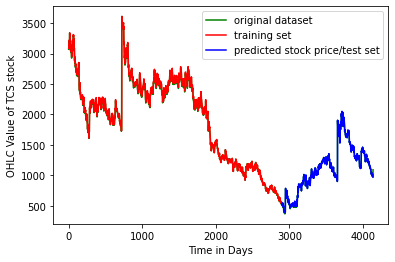

In [ ]:
# Plotting results

plt.plot(ohlcAVG, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of ' + symbol + ' stock')
plt.show()

In [ ]:
# Predicting value

STOCK = yf.Ticker(symbol)
lastValue = STOCK.info['currentPrice']

last_val = np.array([lastValue])
last_val_scaled = last_val/last_val
next_val = MODEL.predict(np.reshape(last_val_scaled, (1,1,1)))
print ("Last Day Value:", last_val[0])
print ("Next Day Value:", last_val[0]*next_val[0][0])

Last Day Value: 10.03
Next Day Value: 10.008206537961959
